In [1]:
%load_ext autoreload
%autoreload 2
from tqdm import tqdm
from src.classes.ClassFractionalBiPotential import FractionalBiPotential
from src.classes.ClassFractionalQuadSin import FractionalQuadSin
import matplotlib.pyplot as plt
import numpy as np
from src.classes.ClassFractionalSinLog import FractionalSinLog
from configs.RecursiveVPSDE.Markovian_fQuadSinHF.recursive_Markovian_PostMeanScore_fQuadSinHF2_LowFTh_T256_H05_tl_110data_StbleTgt import get_config
#from configs.RecursiveVPSDE.Markovian_fSinLog.recursive_Markovian_PostMeanScore_fSinLog_LowFTh_T256_H05_tl_110data_StbleTgt import get_config
#from configs.RecursiveVPSDE.Markovian_fBiPot.recursive_Markovian_PostMeanScore_fBiPot_LowFTh_T256_H05_tl_110data_StbleTgt import get_config

# From A ridge estimator of the drift from discrete repeated observations of the solutions of a stochastic differential equation (Denis et al 2021)

In [2]:
config = get_config()

In [3]:
def rmse_ignore_nans(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)  # Ignore NaNs in both arrays
    return np.mean((y_true[mask] - y_pred[mask]) ** 2)

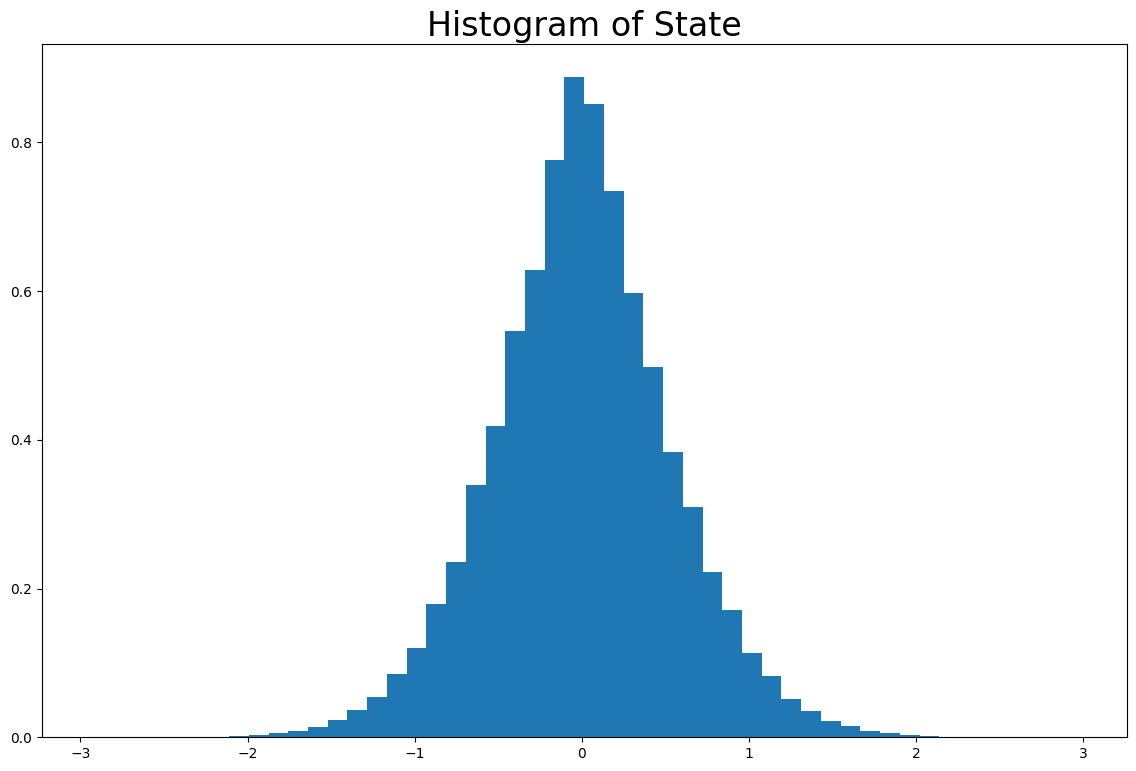

In [4]:
num_paths = 1024 if config.feat_thresh == 1. else 10240
num_time_steps = config.ts_length
isUnitInterval = True
diff = config.diffusion
initial_state = config.initState
rvs = None
H = config.hurst
deltaT = config.deltaT
t0 = config.t0
t1 = deltaT * num_time_steps
try:
    paths = np.load(config.data_path, allow_pickle=True)[:num_paths, :]
    paths = np.concatenate(
        [np.repeat(np.array(config.initState).reshape((1, 1)), paths.shape[0], axis=0),
         paths], axis=1)
    assert paths.shape == (num_paths, config.ts_length + 1)
except (FileNotFoundError, AssertionError) as e:
    print(e)
    if "QuadSin" in config.data_path:
        fQuadSin = FractionalQuadSin(quad_coeff=config.quad_coeff, sin_coeff= config.sin_coeff, sin_space_scale=config.sin_space_scale, diff=diff, X0=initial_state)
        paths = np.array(
            [fQuadSin.euler_simulation(H=H, N=num_time_steps, deltaT=deltaT, isUnitInterval=isUnitInterval, X0=initial_state, Ms=None, gaussRvs=rvs,
                                   t0=t0, t1=t1) for _ in (range(num_paths))]).reshape(
            (num_paths, num_time_steps+1))
    elif "fSinLog" in config.data_path:
        paths = np.load(config.data_path, allow_pickle=True)[:num_paths, :]
        paths = np.concatenate(
            [np.repeat(np.array(config.initState).reshape((1, 1)), paths.shape[0], axis=0),
             paths], axis=1)
        print(paths.shape, num_paths, config.ts_length + 1)
        assert paths.shape == (num_paths, config.ts_length + 1)

    elif "fBiPot" in config.data_path:
        fBiPot = FractionalBiPotential(num_dims=config.ndims, const=config.const, quartic_coeff=config.quartic_coeff, quad_coeff = config.quad_coeff, diff=diff, X0=initial_state)
        paths = np.array(
            [fBiPot.euler_simulation(H=H, N=num_time_steps, deltaT=deltaT, isUnitInterval=isUnitInterval, X0=initial_state, Ms=None, gaussRvs=rvs,
                                   t0=t0, t1=t1) for _ in (range(num_paths))]).reshape(
            (num_paths, num_time_steps+1))

fig, ax = plt.subplots(figsize=(14,9))
plt.hist(paths.flatten(), bins=50, density=True)
plt.title("Histogram of State", fontsize=24)
plt.show()
plt.close()


In [5]:
print(np.min(paths), np.max(paths))
for k in range(num_paths, 1000):
    plt.plot(np.arange(1, 258), paths[k,:])
plt.show()

-2.9366880431359172 2.9662860144905068


In [6]:
def spline_basis(paths, KN, AN, BN, M):
    assert (paths.shape[0] >= 1 and len(paths.shape)==2)
    assert (AN < BN and KN > 0 and M > 0)
    def construct_ith_knot(i, AN, BN, KN):
        if i < 0:
            return AN
        elif i > KN:
            return BN
        else:
            return AN + i*(BN-AN)/KN
    def bspline(i, l, u, x, KN, M):
        if l == 0 and -M <= i <= KN+M-1:
            return ((u[i] <= x) & (x < u[i+1])).astype(float)
        elif 1 <= l <= M  and -M <= i <= KN+M-l-1:
            num1 = ((x-u[i])/(u[i+l]-u[i]))
            num1[np.isinf(num1)] = 0.
            num2 = ((-x+u[i+l+1])/(u[i+l+1]-u[i+1]))
            num2[np.isinf(num2)] = 0.
            return num1*bspline(i=i,l=l-1, u=u, x=x, KN=KN, M=M)+num2*bspline(i=i+1, l=l-1, u=u, x=x, KN=KN, M=M)

    knots = {i:construct_ith_knot(i, AN, BN, KN) for i in range(-M, KN+M+1)}
    if paths.shape[1] > 1:
        paths = paths[:,:-1].flatten()
    else:
        paths = paths.flatten()
    basis = np.array([bspline(i=i, l=M, u=knots, x=paths, KN=KN,M=M) for i in range(-M, KN)]).T
    assert (basis.shape == (paths.shape[0], KN+M)), f"Basis is shape {basis.shape} but should be {(paths.shape[0], KN+M)}"
    assert np.all(basis >= 0.)
    return basis

import scipy
def find_optimal_estimator_coeffs(B, Z, KN, LN, M):
    # Precompute certain matrices
    BTB = B.T@B
    BTZ = (B.T@Z)
    const = (KN+M)*LN
    if np.all(np.linalg.eigvalsh(BTB)>0.):
        print(f"Matrix BTB is invertible\n")
        a = np.linalg.inv(BTB)@BTZ
        if a.T@a <= const:
            print(f"L2 norm of coefficients automatically satisfies projection constraint\n")
            return a
    I = np.eye(KN+M)
    def obj(l):
        inv = np.linalg.inv(BTB+l*I) @ BTZ
        return np.abs(inv.T@inv - const)
    opt = scipy.optimize.minimize(obj, max(0.,-np.min(np.linalg.eigvalsh(BTB)))+1e-12)
    lhat = np.inf
    while not (opt.success) and not np.allclose(lhat, opt.x):
        lhat = opt.x
        opt = scipy.optimize.minimize(obj, opt.x)
    lhat = opt.x[0]
    a = np.atleast_2d(np.linalg.inv(BTB+lhat*I)@BTZ)
    assert (np.allclose(a.T@a , const))
    return a

def construct_estimator(coeffs, B, LN):
    drift  = B@coeffs
    drift[np.abs(drift) > np.sqrt(LN)] = np.sqrt(LN)*np.sign(drift[np.abs(drift) > np.sqrt(LN)])
    return drift


In [7]:
config.data_path

'/Users/marcos/GitHubRepos/FractionalBrownianMotion/data/fQuadSinHF_samples_t00_dT3906e-03_T256_05a_004b_250c_10Diff_00Init.npy'

In [8]:
AN = -1.5
BN = -AN
M = 2
LN = np.log(num_paths)
KNs = {2**p: np.inf for p in [0, 1, 3, 4, 5]}
for KN in list(KNs.keys()):
    break
    B = spline_basis(paths=paths[:num_paths,:], KN=KN, AN=AN, BN=BN, M=M)
    Z = np.power(deltaT,-1)*np.diff(paths[:num_paths,:], axis=1).reshape((paths[:num_paths,:].shape[0]*(paths.shape[1]-1),1))
    assert (B.shape[0] == Z.shape[0] and len(B.shape)==len(Z.shape) == 2)
    coeffs = find_optimal_estimator_coeffs(B=B, Z=Z, KN=KN, LN=LN, M=M)
    drift = construct_estimator(coeffs=coeffs, B=B, LN=LN).flatten()
    KNs[KN] = np.mean(np.power(drift-Z.flatten(),2)) + 0.1*np.power(np.log(num_paths),2)*(KN+M)/num_paths
#KN = list(dict(sorted(KNs.items(), key= lambda item: item[1])).keys())[0]

In [9]:
if "fQuadSin" in config.data_path:
    minx = -1.5
    assert config.sin_space_scale == 25.
    ts_type = "fQuadSin2"
    label = "$\mu_{2}$"
    dirname = "QuadSinHF2"
elif "fSinLog" in config.data_path:
    minx = -1.5
    ts_type = "fSinLog"
    label = "$\mu_{1}$"
    dirname = "SinLog"
elif "fBiPot" in config.data_path:
    minx = -1.5
    ts_type = "fBiPot"
    label = "$\mu_{3}$"
    dirname = "BiPot"
maxx = -minx

In [10]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return

In [ ]:
KNS = np.arange(1, 60, 1)
curr_rmse = np.inf
for KN in KNS:
    B = spline_basis(paths=paths[:num_paths,:], KN=KN, AN=AN, BN=BN, M=M)
    Z = np.power(deltaT,-1)*np.diff(paths[:num_paths,:], axis=1).reshape((paths[:num_paths,:].shape[0]*(paths.shape[1]-1),1))
    assert (B.shape[0] == Z.shape[0] and len(B.shape)==len(Z.shape) == 2)
    coeffs = find_optimal_estimator_coeffs(B=B, Z=Z, KN=KN, LN=LN, M=M)
    ppaths = np.linspace(AN-0.5, BN+0.5, config.ts_length).reshape(1, -1)
    if "QuadSin" in config.data_path:
        unif_true_drift = -2.*config.quad_coeff * ppaths[:,:-1].flatten() + config.sin_coeff * config.sin_space_scale*np.sin(config.sin_space_scale*ppaths[:,:-1].flatten())
    elif "fSinLog" in config.data_path:
        unif_true_drift = (-np.sin(config.sin_space_scale*ppaths[:,:-1].flatten())*np.log(1+config.log_space_scale*np.abs(ppaths[:,:-1].flatten()))/config.sin_space_scale).flatten()
    elif "BiPot" in config.data_path:
        unif_true_drift = -(4.*config.quartic_coeff * np.power(ppaths[:,:-1], 3) + 2.*config.quad_coeff * ppaths[:,:-1] + config.const).flatten()
    unif_true_drift[ppaths[:,:-1].flatten() < AN] = np.nan
    unif_true_drift[ppaths[:,:-1].flatten() > BN] = np.nan
    unif_B = spline_basis(paths=ppaths[:,:], KN=KN, AN=AN, BN=BN, M=M)
    unif_drift = construct_estimator(coeffs=coeffs, B=unif_B, LN=LN).flatten()
    unif_drift[ppaths[:,:-1].flatten() < AN] = np.nan
    unif_drift[ppaths[:,:-1].flatten() > BN] = np.nan
    rmse = (rmse_ignore_nans(unif_true_drift, unif_drift))
    if rmse < curr_rmse:
        curr_rmse = rmse
        fig, ax = plt.subplots(figsize=(14,9))
        plt.scatter(ppaths[:,:-1].flatten(), unif_true_drift, label="True Drift", color="red")
        plt.scatter(ppaths[:,:-1].flatten(), unif_drift, label="Estimated Drift",color="blue")
        plt.title(rf"Ridge Estimator for {label}", fontsize=40)
        ax.tick_params(labelsize=38)
        plt.grid(True)
        plt.ylabel("Drift Value", fontsize=38)
        plt.xlabel(r"State $Y$", fontsize=38)
        plt.legend(fontsize=24)
        plt.tight_layout()
        plt.savefig(f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/DiffusionModelPresentationImages/Ridge/{dirname}/Ridge_{ts_type}_DriftEvalExp_{KN}KN_{M}M".replace(".","")+".png",  bbox_inches='tight')
        plt.show()
        plt.close()
        print(f"MSE {rmse} for KN {KN}")
# KN=1, M=3 for fBiPot
# KN=43, M=2 for fQuadSin2 (high frequency for clean report)
# KN = 8, m=2 for SinLog

In [11]:
def true_drift(prev, num_paths, config):
    assert (prev.shape == (num_paths, config.ndims))
    if "BiPot" in config.data_path:
        drift_X = -(4. * config.quartic_coeff * np.power(prev, 3) + 2. * config.quad_coeff * prev + config.const)
    elif "QuadSin" in config.data_path:
        drift_X = -2. * config.quad_coeff * prev + config.sin_coeff * config.sin_space_scale * np.sin(
        config.sin_space_scale * prev)
    elif "SinLog" in config.data_path:
        drift_X = (-np.sin(config.sin_space_scale*prev)*np.log(1+config.log_space_scale*np.abs(prev))/config.sin_space_scale)
    return drift_X[:, np.newaxis, :]


/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_3964/3788290958.py:15: RuntimeWarning: divide by zero encountered in divide
  num1 = ((x-u[i])/(u[i+l]-u[i]))
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_3964/3788290958.py:17: RuntimeWarning: divide by zero encountered in divide
  num2 = ((-x+u[i+l+1])/(u[i+l+1]-u[i+1]))


Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint



100%|██████████| 2/2 [00:00<00:00,  7.47it/s]
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_3964/3766469089.py:45: RuntimeWarning: invalid value encountered in divide
  total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_3964/3766469089.py:46: RuntimeWarning: invalid value encountered in divide
  all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

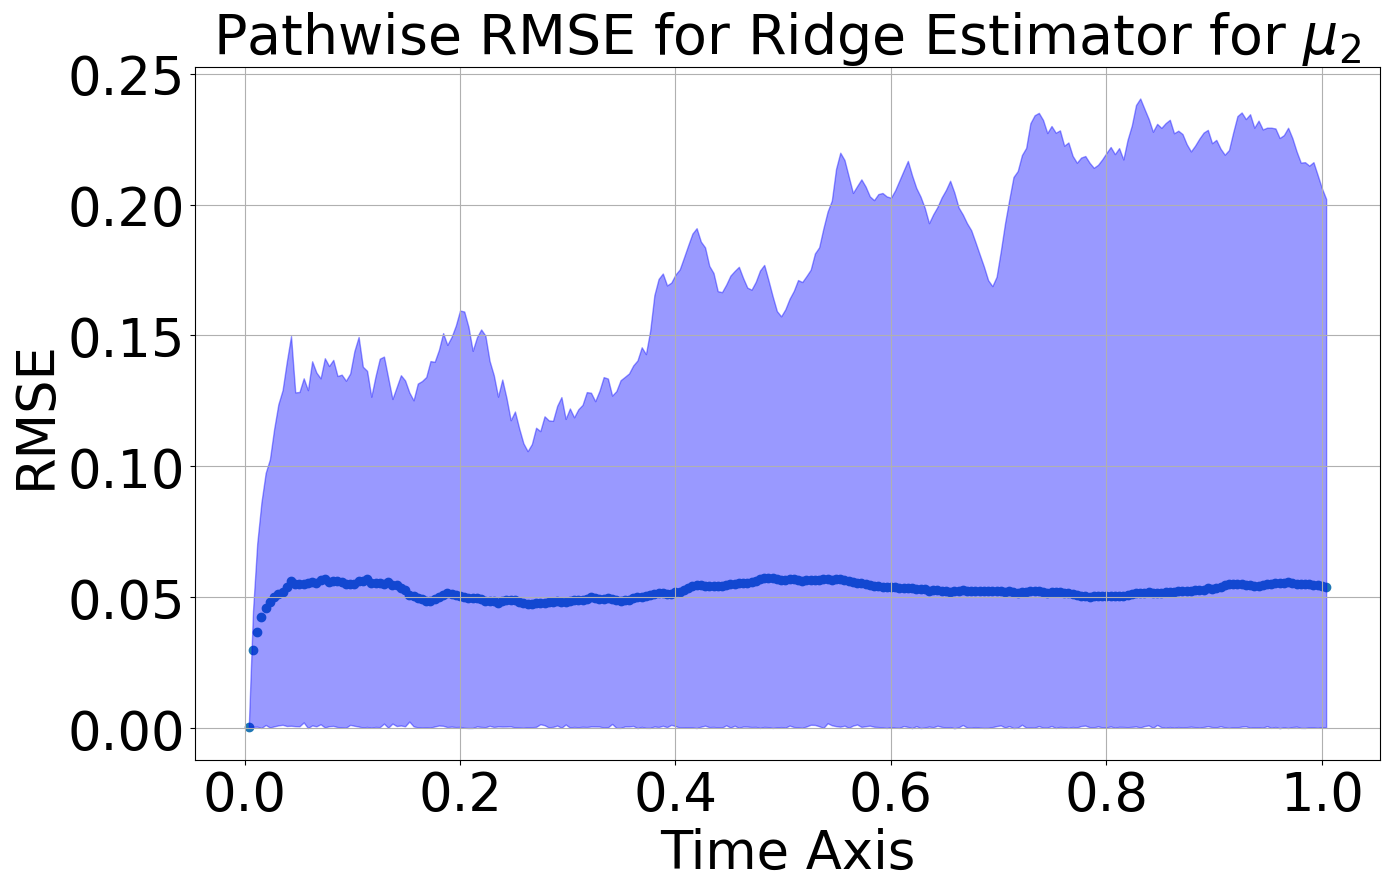

Final time cumulative MSE local-time error 0.05388719138279186 with IQR (0.0003285631816405209, 0.20216344893114346) at KN 1

Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint



100%|██████████| 2/2 [00:00<00:00,  5.81it/s]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:00<00:00,  5.31it/s]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:00<00:00,  4.69it/s]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:00<00:00,  4.00it/s]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:00<00:00,  3.79it/s]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:00<00:00,  3.02it/s]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:00<00:00,  3.15it/s]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:00<00:00,  3.02it/s]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:00<00:00,  2.41it/s]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:00<00:00,  2.61it/s]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:01<00:00,  1.94it/s]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:00<00:00,  2.08it/s]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

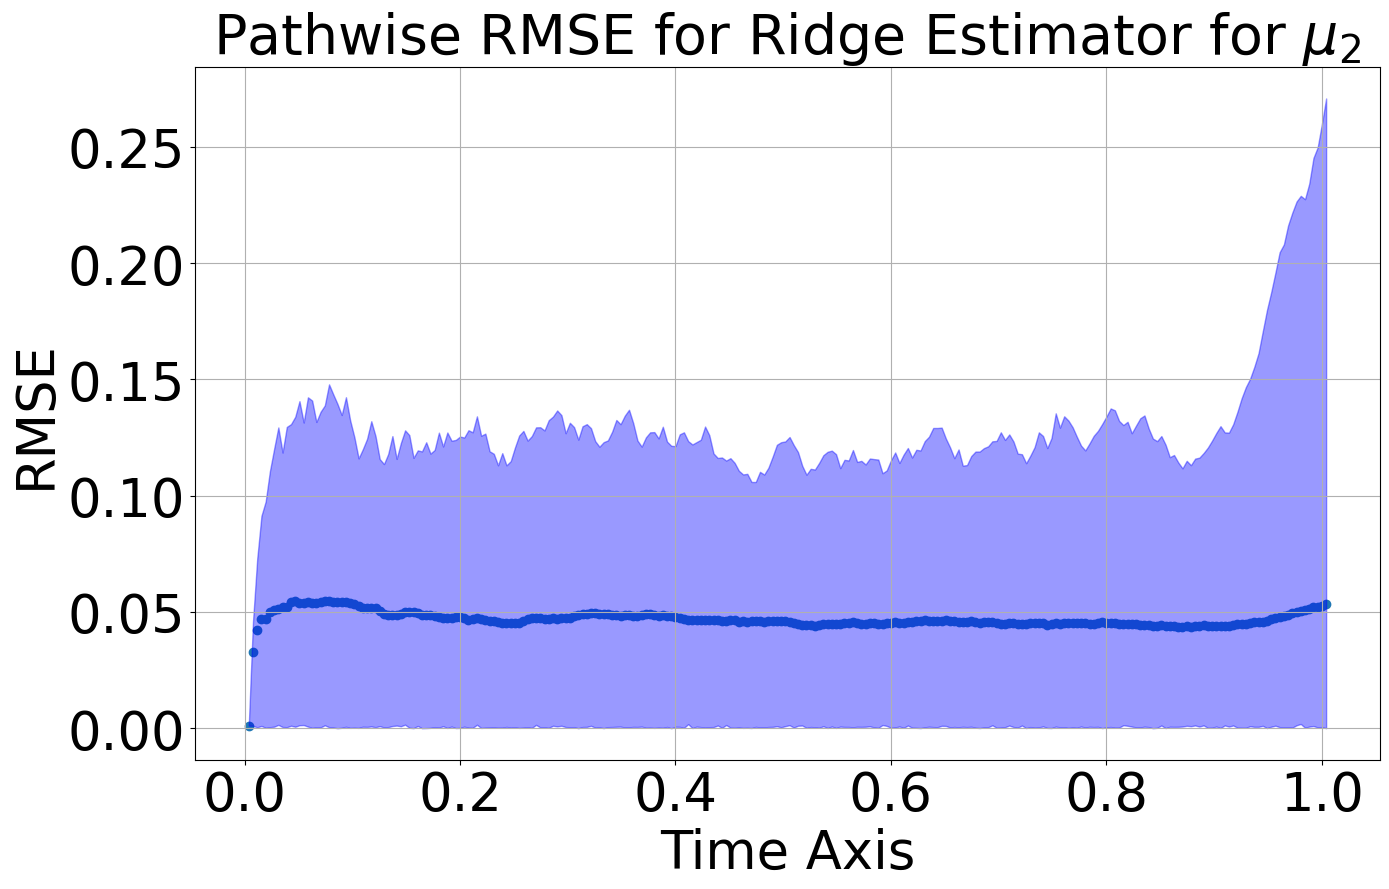

Final time cumulative MSE local-time error 0.05340053954046092 with IQR (4.329136758144047e-05, 0.27076404468286286) at KN 15

Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint



100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:01<00:00,  1.95it/s]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:01<00:00,  1.84it/s]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:01<00:00,  1.82it/s]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:01<00:00,  1.73it/s]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:01<00:00,  1.65it/s]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:01<00:00,  1.64it/s]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:01<00:00,  1.39it/s]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:01<00:00,  1.37it/s]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:01<00:00,  1.32it/s]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:01<00:00,  1.31it/s]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

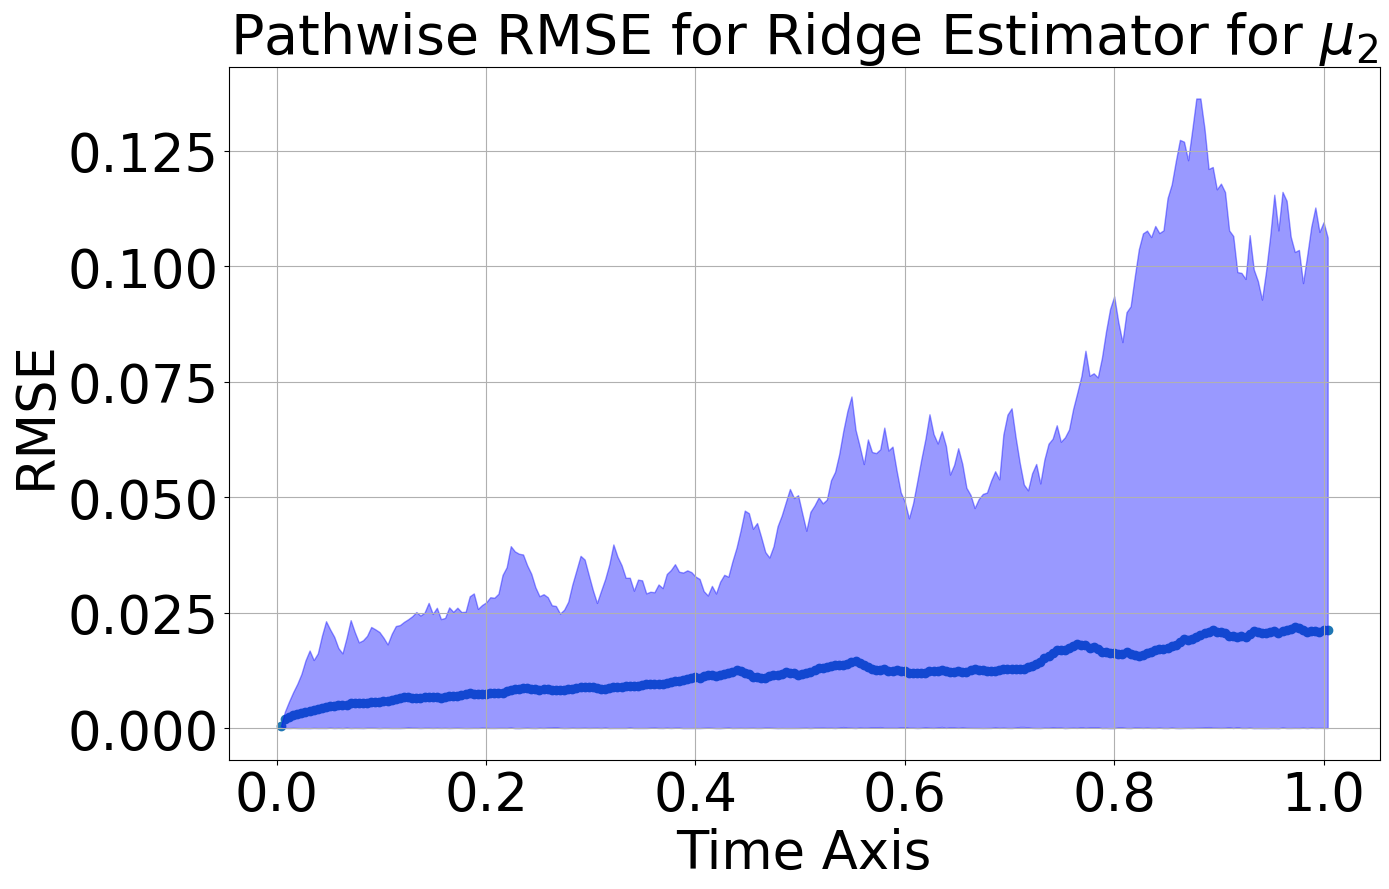

Final time cumulative MSE local-time error 0.021338468743420703 with IQR (4.623279612341016e-05, 0.10625774211476459) at KN 43

Matrix BTB is invertible

L2 norm of coefficients automatically satisfies projection constraint



100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:02<00:00,  1.43s/it]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:03<00:00,  1.85s/it]


[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

100%|██████████| 2/2 [00:03<00:00,  1.57s/it]

[0.         0.00392151 0.00784302 0.01176453 0.01568604 0.01960754
 0.02352905 0.02745056 0.03137207 0.03529358 0.03921509 0.0431366
 0.04705811 0.05097961 0.05490112 0.05882263 0.06274414 0.06666565
 0.07058716 0.07450867 0.07843018 0.08235168 0.08627319 0.0901947
 0.09411621 0.09803772 0.10195923 0.10588074 0.10980225 0.11372375
 0.11764526 0.12156677 0.12548828 0.12940979 0.1333313  0.13725281
 0.14117432 0.14509583 0.14901733 0.15293884 0.15686035 0.16078186
 0.16470337 0.16862488 0.17254639 0.1764679  0.1803894  0.18431091
 0.18823242 0.19215393 0.19607544 0.19999695 0.20391846 0.20783997
 0.21176147 0.21568298 0.21960449 0.223526   0.22744751 0.23136902
 0.23529053 0.23921204 0.24313354 0.24705505 0.25097656 0.25489807
 0.25881958 0.26274109 0.2666626  0.27058411 0.27450562 0.27842712
 0.28234863 0.28627014 0.29019165 0.29411316 0.29803467 0.30195618
 0.30587769 0.30979919 0.3137207  0.31764221 0.32156372 0.32548523
 0.32940674 0.33332825 0.33724976 0.34117126 0.34509277 0.349014

In [12]:
best_rmse = np.inf
toSave = False
num_time_steps = config.ts_length
num_state_paths = 100
rmse_quantile_nums = 2
LN = np.log(num_paths)
KNS = np.arange(1, 60, 1)
for k_idx in range(len(KNS)):
    KN = KNS[k_idx]
    all_true_states = np.zeros(shape=(rmse_quantile_nums, num_state_paths, 1 + num_time_steps, config.ndims))
    all_global_states = np.zeros(shape=(rmse_quantile_nums, num_state_paths, 1 + num_time_steps, config.ndims))
    all_local_states = np.zeros(shape=(rmse_quantile_nums, num_state_paths, 1 + num_time_steps, config.ndims))
    assert (all_true_states.shape == all_global_states.shape)
    B = spline_basis(paths=paths[:num_paths,:], KN=KN, AN=AN, BN=BN, M=M)
    Z = np.power(deltaT,-1)*np.diff(paths[:num_paths,:], axis=1).reshape((paths[:num_paths,:].shape[0]*(paths.shape[1]-1),1))
    assert (B.shape[0] == Z.shape[0] and len(B.shape)==len(Z.shape) == 2)
    coeffs = find_optimal_estimator_coeffs(B=B, Z=Z, KN=KN, LN=LN, M=M)
    for quant_idx in tqdm(range(rmse_quantile_nums)):
        true_states = np.zeros(shape=(num_state_paths, 1 + num_time_steps, config.ndims))
        global_states = np.zeros(shape=(num_state_paths, 1 + num_time_steps, config.ndims))
        local_states = np.zeros(shape=(num_state_paths, 1 + num_time_steps, config.ndims))
        # Initialise the "true paths"
        true_states[:, [0], :] = config.initState
        global_states[:, [0], :] = config.initState
        local_states[:, [0], :] = config.initState
        for i in (range(1, num_time_steps + 1)):
            eps = np.random.randn(num_state_paths, 1, config.ndims) * np.sqrt(deltaT)
            assert (eps.shape == (num_state_paths, 1, config.ndims))
            true_mean = true_drift(true_states[:, i - 1, :], num_paths=num_state_paths, config=config)
            global_basis = spline_basis(paths=global_states[:, i - 1, :], KN=KN, AN=AN, BN=BN, M=M)
            local_basis = spline_basis(paths=true_states[:, i - 1, :], KN=KN, AN=AN, BN=BN, M=M)
            local_mean = construct_estimator(coeffs=coeffs, B=local_basis, LN=LN)[:, np.newaxis, :]
            global_mean = construct_estimator(coeffs=coeffs, B=global_basis, LN=LN)[:, np.newaxis, :]
            true_states[:, [i], :] = true_states[:, [i - 1], :] + true_mean * deltaT + eps
            global_states[:, [i], :] = global_states[:, [i - 1], :] + global_mean * deltaT + eps
            local_states[:, [i], :] = true_states[:, [i - 1], :] + local_mean * deltaT + eps
        all_true_states[quant_idx, :, :, :] = true_states
        all_local_states[quant_idx, :, :, :] = local_states
        all_global_states[quant_idx, :, :, :] = global_states

    time_steps = np.linspace(config.t0,config.deltaT*all_true_states.shape[2],all_true_states.shape[2])
    print(time_steps)
    all_global_errors = np.sum(np.power(all_true_states- all_global_states,2), axis=-1)
    all_global_errors=all_global_errors.reshape(-1, all_global_errors.shape[-1])            # (K, N, T)
    total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
    all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)
    total_local_errors[total_local_errors==np.inf] = 0.
    all_paths_err[all_paths_err==np.inf] = 0.
    total_local_errors_minq, total_local_errors_maxq  = np.quantile(all_paths_err, q=[0.005, 0.995], axis=0) # (T,)
    print(total_local_errors[-1], (total_local_errors_minq[-1], total_local_errors_maxq[-1]), best_rmse)
    if total_local_errors[-1]  < best_rmse:
        best_rmse = total_local_errors[-1]
        fig, ax = plt.subplots(figsize=(14,9))
        plt.grid(True)
        ax.scatter(time_steps, total_local_errors)
        plt.fill_between(time_steps,y1=total_local_errors_minq, y2=total_local_errors_maxq, color="blue", alpha=0.4)
        ax.set_title(f"Pathwise RMSE for Ridge Estimator for {label}",fontsize=40)
        plt.tight_layout()
        ax.set_xlabel("Time Axis", fontsize=38)
        ax.tick_params(labelsize=38)

        fig.canvas.draw()
        # Get the offset text (e.g., '1e-5')
        offset_text = ax.yaxis.get_offset_text().get_text()

        # Remove the offset text from the axis
        ax.yaxis.get_offset_text().set_visible(False)

        # Inject the scale into the y-axis label
        if offset_text:
            ax.set_ylabel(f'RMSE ({offset_text})', fontsize=38)
        else:
            ax.set_ylabel('RMSE', fontsize=38)
        plt.tight_layout()
        if toSave:
            plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/DiffusionModelPresentationImages/Ridge/{dirname}/Ridge_{ts_type}_DriftTrack_{KN}KN_{M}M_{round(total_local_errors_minq[-1], 8)}_MinIQR_{round(total_local_errors_maxq[-1], 8)}_MaxIQR").replace(".", "")+".png")
        plt.show()
        plt.close()
        print(f"Final time cumulative MSE local-time error {total_local_errors[-1]} with IQR {(total_local_errors_minq[-1], total_local_errors_maxq[-1])} at KN {KN}\n")
